In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate graduation rate

In [3]:
# keep only non-zero international completers, & at least 3 international students in 2017 cohort
data_intl_grad = data[data.GRNRALT_x > 0] 
data_intl_grad = data_intl_grad[data_intl_grad.GRNRALT_y > 2] 
data_intl_grad.shape # (1222, 300)

(1222, 300)

Text(0.5, 0, 'graduation rate')

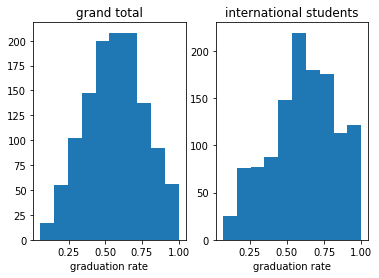

In [13]:
#'GRTOTLT', 'GRNRALT'

plt.subplot(1,2,1)
plt.hist(data_intl_grad['GRTOTLT_rate'])
plt.title('grand total')
plt.xlabel('graduation rate')
plt.subplot(1,2,2)
plt.hist(data_intl_grad['GRNRALT_rate']) 
plt.title('international students')
plt.xlabel('graduation rate') 

(array([ 93., 952., 142.,  27.,   5.,   2.,   0.,   0.,   0.,   1.]),
 array([0.3705458 , 0.82406767, 1.27758955, 1.73111142, 2.1846333 ,
        2.63815518, 3.09167705, 3.54519893, 3.99872081, 4.45224268,
        4.90576456]),
 <a list of 10 Patch objects>)

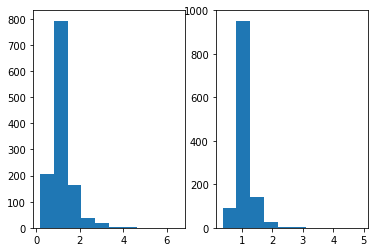

In [35]:
# calculate an adjusted proportion with Bayesian formula
# but first, look at a general distribution of 
plt.subplot(1,2,1)
plt.hist(data_intl_grad['GRNRALT_rate']/data_intl_grad['GRTOTLT_rate'])
plt.subplot(1,2,2)
plt.hist(graduation_ratio)
# most are close to 1
# so I can use the grand total proportion as my prior

In [9]:
GRNRALT_rate_adj = (data_intl_grad['GRNRALT_x'] + 10*data_intl_grad['GRTOTLT_rate'])/(data_intl_grad['GRNRALT_y'] + 10)
GRNRALT_rate_adj.describe()
graduation_ratio = GRNRALT_rate_adj/data_intl_grad['GRTOTLT_rate']
graduation_ratio.describe()
data_intl_grad['GRNRALT_rate_adj'] = GRNRALT_rate_adj
data_intl_grad['graduation_ratio'] = graduation_ratio
# need success and failure numbers for binomial regression
data_intl_grad['EFYUS'] = data_intl_grad['EFYTOTLT'] - data_intl_grad['EFYNRALT']

(array([ 26.,  62.,  74., 152., 193., 233., 199., 136.,  98.,  49.]),
 array([0.10853396, 0.19768056, 0.28682717, 0.37597377, 0.46512038,
        0.55426698, 0.64341358, 0.73256019, 0.82170679, 0.9108534 ,
        1.        ]),
 <a list of 10 Patch objects>)

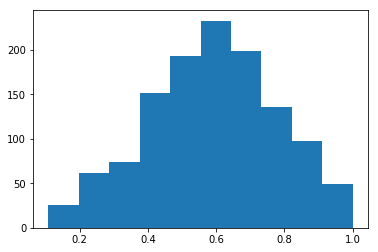

In [32]:
plt.hist(GRNRALT_rate_adj)

In [60]:
# look at who have >90% completion rate
# data_intl_grad[data_intl_grad.GRNRALT_rate>0.9][['INSTNM','ranking_US_news','GRNRALT_x','GRNRALT_y','GRTOTLT_rate','GRNRALT_rate_adj']]
# they are a mix of very great schools and schools with very small international enrollment

In [59]:
# look at who have graduation ratio > 3
#data_intl_grad[data_intl_grad.graduation_ratio>2][['INSTNM','ranking_US_news','GRNRALT_x','GRNRALT_y','GRTOTLT_rate','GRNRALT_rate_adj']]
# they are a mix of very great schools and schools with very small international enrollment
# for now, I'm not worrying about it because all >2 schools either don't have a ranking or have a 293 ranking

In [45]:
data_274_intl_grad_national_u = data_intl_grad.dropna(subset = ['ranking_US_news','good_for_intl_US_news'])
print(data_274_intl_grad_national_u.shape) # (274, 302)
#data_274_intl_grad_national_u[['good_for_intl_US_news','diverse_ind','graduation_ratio']]
data_274_intl_grad_national_u.to_csv('Data/Data national universities 274.csv')

(274, 303)


# EDA

In [16]:
features = ['diverse_ind','GRNRALT_rate','tuition_US_news', 'ranking_US_news', 'good_for_intl_US_news']

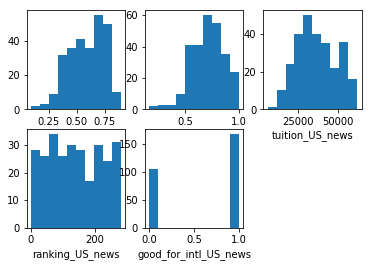

In [8]:
# look at the distributions of my features

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.hist(data_274_intl_grad_national_u[features[i]])
    plt.xlabel(features[i])
#plt.subplot(2,3,6)
#plt.hist(data_274_intl_grad_national_u['intl_pct'])
#plt.xlabel('intl_pct')

6
['diverse_ind', 'GRNRALT_rate', 'tuition_US_news', 'ranking_US_news', 'good_for_intl_US_news', 'intl_pct']


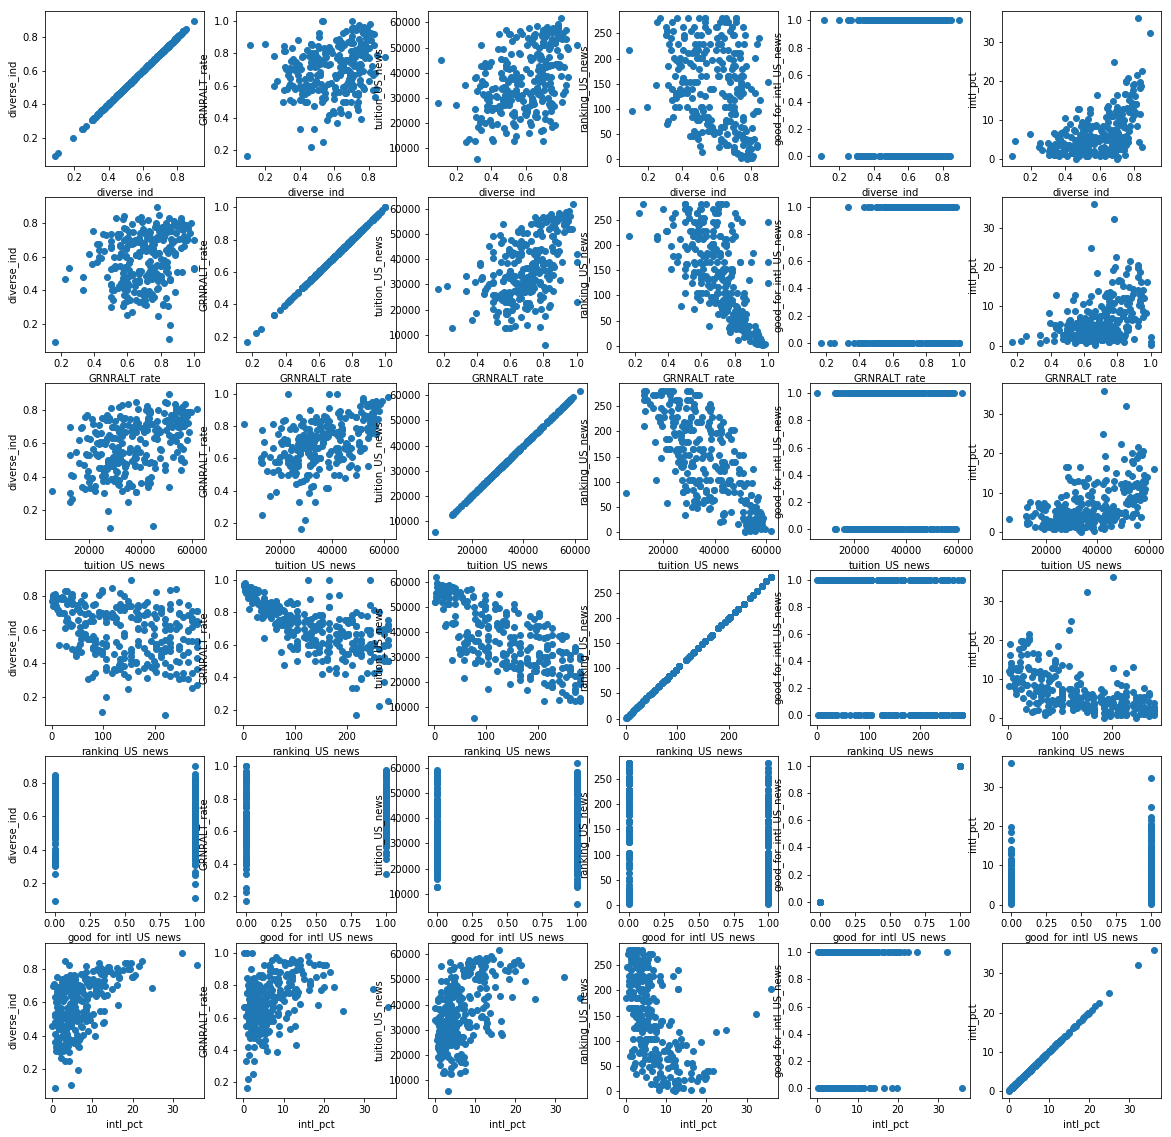

In [20]:

all_vars =['diverse_ind','GRNRALT_rate','tuition_US_news', 'ranking_US_news', 'good_for_intl_US_news','intl_pct']
print(len(all_vars))
print(all_vars)
plt.figure(figsize=(20,20))
c = 0
for i in range(len(all_vars)):
    for j in range(len(all_vars)):
        c += 1
        plt.subplot(6,6,c)
        plt.scatter(data_274_intl_grad_national_u[all_vars[i]],data_274_intl_grad_national_u[all_vars[j]])
        plt.xlabel(all_vars[i])
        plt.ylabel(all_vars[j])


# Binomial regression

In [2]:
data_274_intl_grad_national_u = pd.read_csv('Data/Data national universities 274.csv')

In [4]:
from sklearn.model_selection import train_test_split
np.random.seed(922)
train, test = train_test_split(data_274_intl_grad_national_u, test_size = 0.3)

In [5]:
# fit binomial regression model
features = ['diverse_ind','graduation_ratio','tuition_US_news', 'good_for_intl_US_news']
import statsmodels.api as sm
binomial_model=sm.GLM(
    train[['EFYNRALT','EFYUS']], #[success, failure]
    train[features],
    family = sm.families.Binomial())
result=binomial_model.fit()
print(result.summary())
result.params

                   Generalized Linear Model Regression Results                   
Dep. Variable:     ['EFYNRALT', 'EFYUS']   No. Observations:                  191
Model:                               GLM   Df Residuals:                      187
Model Family:                   Binomial   Df Model:                            3
Link Function:                     logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -45999.
Date:                   Tue, 01 Oct 2019   Deviance:                       90449.
Time:                           11:08:03   Pearson chi2:                 9.77e+04
No. Iterations:                        7   Covariance Type:             nonrobust
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
diverse_ind               1.3592      0.017     78.327      0.000       1.325     

diverse_ind              1.359193
graduation_ratio        -3.959094
tuition_US_news          0.000013
good_for_intl_US_news    0.041620
dtype: float64

In [74]:
# get prediction
pred_test = result.predict(test[features])
pred_train = result.predict(train[features])

In [77]:
# prediction with new value, MVP
value = 100663
pred0 = result.predict(data_274_intl_grad_national_u[data_274_intl_grad_national_u.UNITID==value][features])
new_x = data_274_intl_grad_national_u[data_274_intl_grad_national_u.UNITID==value][features]
new_x['diverse_ind'] = new_x['diverse_ind']*1.1
new_x
pred1 = result.predict(new_x)
print(pred0)
print(pred1)
print(pred1-pred0)

0    0.058971
dtype: float64
0    0.063364
dtype: float64
0    0.004393
dtype: float64


Text(0, 0.5, 'y')

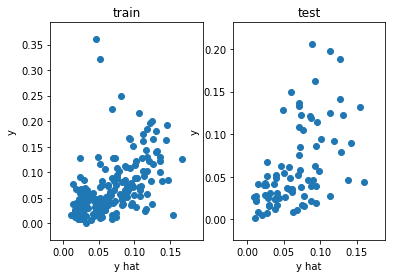

In [75]:
plt.subplot(1,2,1)
plt.scatter(pred_train,train['intl_pct']/100)
plt.title('train')
plt.xlabel('y hat')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.scatter(pred_test,test['intl_pct']/100)
plt.title('test')
plt.xlabel('y hat')
plt.ylabel('y')

Text(0, 0.5, '% Enrolled (Actual)')

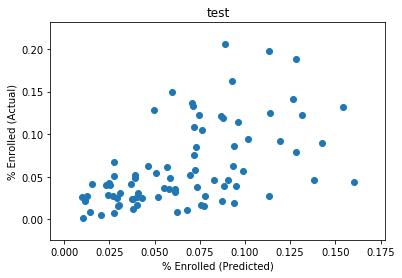

In [78]:
plt.scatter(pred_test,test['intl_pct']/100)
plt.title('test')
plt.xlabel('% Enrolled (Predicted)')
plt.ylabel('% Enrolled (Actual)')

# Binomial Regression - normalized features

In [63]:
# normalization
from sklearn.preprocessing import scale

feat_normalize = scale(data_274_intl_grad_national_u[features[:-1]],  axis=0)
feat_normalize = pd.DataFrame(feat_normalize, columns = [features[:-1]])
#data_274_intl_grad_national_u[features[-1]])))
feat_normalize[features[-1]] = data_274_intl_grad_national_u[features[-1]]
feat_normalize['EFYNRALT'] = data_274_intl_grad_national_u['EFYNRALT']
feat_normalize['EFYUS'] = data_274_intl_grad_national_u['EFYUS']
feat_normalize['ranking_US_news'] = 0 - feat_normalize['ranking_US_news']
feat_normalize.head()

,diverse_ind,GRNRALT_rate,tuition_US_news,ranking_US_news,good_for_intl_US_news,EFYNRALT,EFYUS
0,0.105773,-0.741871,-0.922864,-0.321578,1.0,364,12944
1,-0.362762,-0.871140,-1.107555,-1.503393,0.0,217,7302
2,-1.236848,0.176624,-0.526633,-0.163190,1.0,1030,34595
3,-1.466838,-1.345129,-0.455522,0.433810,0.0,1278,22568
4,-1.726665,-0.017961,-0.315092,-0.090088,0.0,89,3357


In [29]:
from sklearn.model_selection import train_test_split
np.random.seed(922)
train_std, test_std = train_test_split(feat_normalize, test_size = 0.3)

In [67]:
#import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as glm
binomial_normalized=glm.GLM(
    train_std[['EFYNRALT','EFYUS']], #[success, failure]
    train_std[features],
    family = sm.families.Binomial())
for a in range(10):
    result_std=binomial_normalized.fit_regularized(alpha = a/2)
    #print(result_std.summary())
    print(str(a/2) ,result_std.params)

0.0 (diverse_ind,)             -0.208045
(GRNRALT_rate,)             0.176881
(tuition_US_news,)          0.678341
(ranking_US_news,)          0.171118
(good_for_intl_US_news,)   -2.755136
dtype: float64
0.5 (diverse_ind,)             -0.207384
(GRNRALT_rate,)             0.176561
(tuition_US_news,)          0.678066
(ranking_US_news,)          0.170685
(good_for_intl_US_news,)   -2.754027
dtype: float64
1.0 (diverse_ind,)             -0.206724
(GRNRALT_rate,)             0.176242
(tuition_US_news,)          0.677791
(ranking_US_news,)          0.170251
(good_for_intl_US_news,)   -2.752919
dtype: float64
1.5 (diverse_ind,)             -0.206064
(GRNRALT_rate,)             0.175923
(tuition_US_news,)          0.677516
(ranking_US_news,)          0.169818
(good_for_intl_US_news,)   -2.751813
dtype: float64
2.0 (diverse_ind,)             -0.205404
(GRNRALT_rate,)             0.175604
(tuition_US_news,)          0.677241
(ranking_US_news,)          0.169386
(good_for_intl_US_news,)   -2.75

                      diverse_ind GRNRALT_rate tuition_US_news  \
diverse_ind              1.000000     0.248006        0.412043   
GRNRALT_rate             0.248006     1.000000        0.510846   
tuition_US_news          0.412043     0.510846        1.000000   
ranking_US_news          0.328260     0.649361        0.701609   
graduation_ratio         0.037323     0.355887       -0.199537   
good_for_intl_US_news    0.025122     0.299011        0.119891   
EFYNRALT                 0.303243     0.245221        0.064237   
EFYUS                    0.004722     0.038016       -0.387708   

                      ranking_US_news graduation_ratio good_for_intl_US_news  \
diverse_ind                  0.328260         0.037323              0.025122   
GRNRALT_rate                 0.649361         0.355887              0.299011   
tuition_US_news              0.701609        -0.199537              0.119891   
ranking_US_news              1.000000        -0.293598              0.373762   
gradu

([<matplotlib.axis.YTick at 0x1b794d339e8>,
 <a list of 8 Text yticklabel objects>)

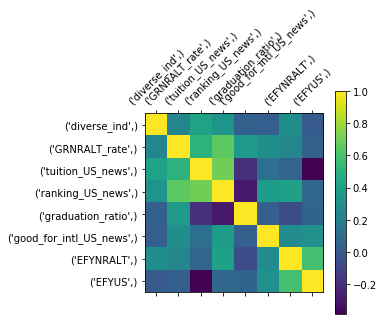

In [44]:
# correlation matrix
import matplotlib.pyplot as plt
print(feat_normalize.corr())
plt.matshow(feat_normalize.corr())
plt.colorbar()
plt.xticks(range(feat_normalize.shape[1]), feat_normalize.columns, fontsize=10, rotation=45)
plt.yticks(range(feat_normalize.shape[1]), feat_normalize.columns, fontsize=10)

In [80]:
binomial_normalized=glm.GLM(
    train_std[['EFYNRALT','EFYUS']], #[success, failure]
    train_std[features],
    family = sm.families.Binomial())
result=binomial_normalized.fit()
print(result.summary())
print(result.params)

                      Generalized Linear Model Regression Results                      
Dep. Variable:     [('EFYNRALT',), ('EFYUS',)]   No. Observations:                  191
Model:                                     GLM   Df Residuals:                      186
Model Family:                         Binomial   Df Model:                            4
Link Function:                           logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -3.2748e+05
Date:                         Mon, 30 Sep 2019   Deviance:                   6.5341e+05
Time:                                 17:51:59   Pearson chi2:                 6.17e+05
No. Iterations:                              6   Covariance Type:             nonrobust
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
('diverse_ind',)  

['diverse_ind', 'GRNRALT_rate', 'tuition_US_news', 'ranking_US_news', 'good_for_intl_US_news']


Text(0.5, 1.0, 'Binomial Regression coefficients')

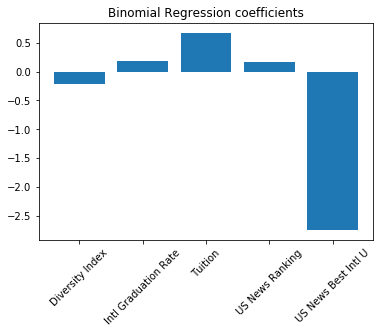

In [81]:
# coefficient plot
print(features)
feature_names = ['Diversity Index', 'Intl Graduation Rate','Tuition','US News Ranking','US News Best Intl U']
plt.bar(x = range(len(result.params)), height = result.params)
plt.xticks(range(len(result.params)), feature_names, rotation = 45)
plt.title('Binomial Regression coefficients')

In [57]:
plt.xticks?

# presentation 

For each institution, I will show a histogram of enrollment percent, with their location highlighted; I will also show their percentile for each feature; I will also show the projected improvement with certain changes!

In [56]:
def get_percentage(arr, reverse = False):
    n = arr.shape[0]
    if reverse == False:
        percentage = arr.rank(ascending=True)/n
    else:
        percentage = arr.rank(ascending=False)/n
    return(percentage)

#get_percentage(pd.Series(range(10)))

0    0.1
1    0.2
2    0.3
3    0.4
4    0.5
5    0.6
6    0.7
7    0.8
8    0.9
9    1.0
dtype: float64

In [62]:
# get the percentage for each feature
larger_good = [True,True,False,False,True]
for i in range(len(features)):
    data_274_intl_grad_national_u[str(features[i])+'_pct'] = get_percentage(
        data_274_intl_grad_national_u[features[i]], larger_good[i])
data_274_intl_grad_national_u.head()

C:\Users\Ning\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,UNITID,EFFYLEV,LSTUDY,XEYTOTLT,EFYTOTLT,XEYTOTLM,EFYTOTLM,XEYTOTLW,EFYTOTLW,XEFYAIAT,...,GRNRALM_rate,GRNRALW _rate,GRNRALT_rate_adj,graduation_ratio,EFYUS,diverse_ind_pct,GRNRALT_rate_pct,tuition_US_news_pct,ranking_US_news_pct,good_for_intl_US_news_pct
1,100663,2,1,R,13308,R,5528,R,7780,R,...,0.461538,0.777778,0.571621,1.080186,12944,0.518248,0.773723,0.189781,0.609489,0.308394
2,100706,2,1,R,7519,R,4287,R,3232,R,...,0.615385,0.000000,0.535915,1.102261,7302,0.620438,0.819343,0.142336,0.921533,0.808394
4,100751,2,1,R,35625,R,15883,R,19742,R,...,0.717647,0.750000,0.725785,1.069330,34595,0.864964,0.467153,0.335766,0.560219,0.308394
8,100858,2,1,R,23846,R,12374,R,11472,R,...,0.466667,0.571429,0.583067,0.761368,22568,0.916058,0.919708,0.364964,0.394161,0.808394
32,102049,2,1,R,3446,R,1197,R,2249,R,...,0.500000,1.000000,0.729032,0.961702,3357,0.956204,0.523723,0.434307,0.536496,0.808394


In [63]:
data_274_intl_grad_national_u.to_csv('Data/Data national universities 274.csv')

In [76]:
data_dropdown = data_274_intl_grad_national_u[['INSTNM','UNITID']]
data_dropdown = data_dropdown.rename(columns={'INSTNM': 'label', 'UNITID': 'value'})
data_dropdown = data_dropdown.T.to_dict()
list(data_dropdown.values())

[{'label': 'University of Alabama at Birmingham', 'value': 100663},
 {'label': 'University of Alabama in Huntsville', 'value': 100706},
 {'label': 'The University of Alabama', 'value': 100751},
 {'label': 'Auburn University', 'value': 100858},
 {'label': 'Samford University', 'value': 102049},
 {'label': 'University of Alaska Fairbanks', 'value': 102614},
 {'label': 'Arizona State University-Tempe', 'value': 104151},
 {'label': 'University of Arizona', 'value': 104179},
 {'label': 'University of Arkansas', 'value': 106397},
 {'label': 'Harding University', 'value': 107044},
 {'label': 'Azusa Pacific University', 'value': 109785},
 {'label': 'Biola University', 'value': 110097},
 {'label': 'California Institute of Technology', 'value': 110404},
 {'label': 'California State University-Fresno', 'value': 110556},
 {'label': 'University of California-Berkeley', 'value': 110635},
 {'label': 'University of California-Davis', 'value': 110644},
 {'label': 'University of California-Irvine', 'val

In [9]:
data = pd.read_csv('Data/Data national universities 274.csv')
data.head()

,Unnamed: 0,UNITID,EFFYLEV,LSTUDY,XEYTOTLT,EFYTOTLT,XEYTOTLM,EFYTOTLM,XEYTOTLW,EFYTOTLW,...,GRNRALM_rate,GRNRALW _rate,GRNRALT_rate_adj,graduation_ratio,EFYUS,diverse_ind_pct,GRNRALT_rate_pct,tuition_US_news_pct,ranking_US_news_pct,good_for_intl_US_news_pct
0,1,100663,2,1,R,13308,R,5528,R,7780,...,0.461538,0.777778,0.571621,1.080186,12944,0.518248,0.773723,0.189781,0.609489,0.308394
1,2,100706,2,1,R,7519,R,4287,R,3232,...,0.615385,0.000000,0.535915,1.102261,7302,0.620438,0.819343,0.142336,0.921533,0.808394
2,4,100751,2,1,R,35625,R,15883,R,19742,...,0.717647,0.750000,0.725785,1.069330,34595,0.864964,0.467153,0.335766,0.560219,0.308394
3,8,100858,2,1,R,23846,R,12374,R,11472,...,0.466667,0.571429,0.583067,0.761368,22568,0.916058,0.919708,0.364964,0.394161,0.808394
4,32,102049,2,1,R,3446,R,1197,R,2249,...,0.500000,1.000000,0.729032,0.961702,3357,0.956204,0.523723,0.434307,0.536496,0.808394


In [18]:
model_coefficients = [-0.1062,1.2622,-2.7071, -4.711e-06, -0.0103 ]
model_coefficients[3]*2

-9.422e-06

# model focusing on scholarship

In [71]:
data = pd.read_csv('Data/Data Merged.csv')

In [72]:
# drop nas based on the scholarship
data289 = data.dropna(subset = ['link'])
data289.shape
#data289.to_csv('Data/data 289.csv', index = False)

(289, 545)

In [74]:
# calculate percent of intl students awarded
pct_awarded = data289.intl_awarded/data289.total_intl
pct_awarded.fillna(0)
pct_awarded
data289.loc[:,'pct_awarded'] = pct_awarded

In [75]:
#data289_tmp = data289.dropna(subset = ['pct_awarded'])
data289.loc[:,'EFYUS'] = data289['EFYTOTLT'] - data289['EFYNRALT']

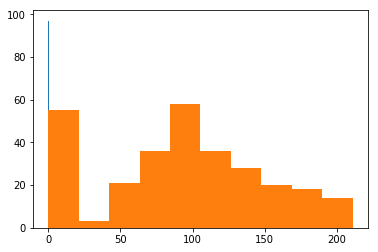

In [76]:
# transform some features
pct_awarded_sqrt = np.sqrt(pct_awarded)
plt.hist(pct_awarded_sqrt)
avg_award_sqrt = np.sqrt(data289['avg_award'])
plt.hist(avg_award_sqrt)
data289.loc[:, 'pct_awarded_sqrt'] = pct_awarded_sqrt
data289.loc[:, 'avg_award_sqrt'] = avg_award_sqrt

In [137]:
from sklearn.preprocessing import scale
features = ['diverse_ind','annual_cost','avg_award','pct_awarded','GRNRALT_rate','TUITION2']
feat_normalize = scale(data289[features],  axis=0)
feat_normalize

array([[-1.71881334, -2.35258618, -0.30011459,  0.96107476, -0.07788337,
        -1.45070864],
       [ 1.32642757,  0.99002496, -0.86089544, -0.68890701,  0.54471895,
         0.26568315],
       [ 1.56973073, -0.05155631, -0.87320707, -0.68890701, -0.73641156,
        -0.0729412 ],
       ...,
       [-0.95732331,  1.69344726, -0.17894224, -0.2232371 , -0.18599993,
         1.26236597],
       [ 0.98542905, -2.354135  , -0.68806978, -0.33189341, -0.37520393,
        -2.15198289],
       [ 0.85218834,  0.21432441, -0.36407953, -0.05888301,         nan,
        -1.93801945]])

(array([ 2.,  0.,  2.,  0.,  1.,  1.,  0.,  1.,  3.,  0.,  4.,  3.,  3.,
         3.,  1.,  1.,  2.,  3.,  4.,  5.,  2.,  3.,  3.,  3.,  7.,  9.,
         7.,  6.,  7.,  7.,  8.,  6.,  9.,  9., 10., 14.,  7., 12.,  6.,
         9., 10., 10.,  9.,  8., 11., 10., 16., 20.,  6.,  6.]),
 array([-2.98750937e+00, -2.89966610e+00, -2.81182283e+00, -2.72397956e+00,
        -2.63613629e+00, -2.54829302e+00, -2.46044975e+00, -2.37260648e+00,
        -2.28476321e+00, -2.19691994e+00, -2.10907667e+00, -2.02123340e+00,
        -1.93339013e+00, -1.84554686e+00, -1.75770359e+00, -1.66986032e+00,
        -1.58201705e+00, -1.49417378e+00, -1.40633051e+00, -1.31848724e+00,
        -1.23064396e+00, -1.14280069e+00, -1.05495742e+00, -9.67114153e-01,
        -8.79270883e-01, -7.91427612e-01, -7.03584342e-01, -6.15741071e-01,
        -5.27897801e-01, -4.40054530e-01, -3.52211260e-01, -2.64367989e-01,
        -1.76524719e-01, -8.86814482e-02, -8.38177725e-04,  8.70050928e-02,
         1.74848363e-01,  2.6269

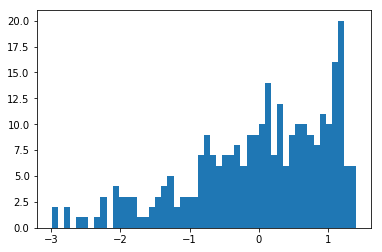

In [87]:
plt.hist(feat_normalize[:,5], bins = 50)

In [88]:
data289.to_csv('Data/data 289.csv')

In [139]:
for i in range(len(features)):
    data289.loc[:,features[i]+'_std'] = feat_normalize[:,i]

In [141]:
features_std = []
for i in range(len(features)):
    features_std.append(features[i]+'_std')
features_std

['diverse_ind_std',
 'annual_cost_std',
 'avg_award_std',
 'pct_awarded_std',
 'GRNRALT_rate_std',
 'TUITION2_std']

In [142]:
data289_tmp = data289.dropna(subset = features)
data289_tmp.shape

(282, 558)

# Remove outliers

In [26]:
# who has > 80% actual enrollment? 
sum(data289_tmp.intl_pct>80)
data289_tmp.INSTNM[data289_tmp.intl_pct>80] # remove Virginia International University
data289_tmp.UNITID[data289_tmp.intl_pct>80] #460376

2997    460376
Name: UNITID, dtype: int64

In [143]:
data289_tmp = data289_tmp[data289_tmp.intl_pct<80]
data289_tmp.shape

(281, 558)

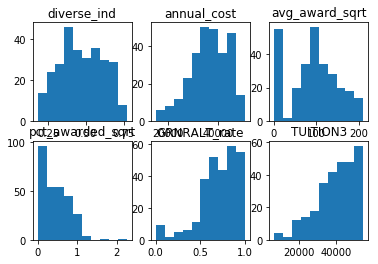

In [94]:
#EDA
for i in range(len(features)):
    plt.subplot(2,3,i+1)
    plt.hist(data289_tmp[features[i]])
    plt.title(features[i])

In [144]:
# remove % awarded that are > 1
data289_tmp = data289_tmp[data289_tmp.pct_awarded<1]
data289_tmp.shape

(262, 558)

In [167]:
# rerun
features_std = ['diverse_ind_std','avg_award_std','pct_awarded_std','GRNRALT_rate_std','TUITION2_std']
import statsmodels.api as sm
X = sm.add_constant(data289_tmp[features_std], prepend=False)
binomial_scholarship=sm.GLM(
    data289_tmp[['EFYNRALT','EFYUS']], #[success, failure]
    X,
    family = glm.families.Binomial())
result=binomial_scholarship.fit()
print(result.summary())


                   Generalized Linear Model Regression Results                   
Dep. Variable:     ['EFYNRALT', 'EFYUS']   No. Observations:                  262
Model:                               GLM   Df Residuals:                      256
Model Family:                   Binomial   Df Model:                            5
Link Function:                     logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -29696.
Date:                   Thu, 03 Oct 2019   Deviance:                       57559.
Time:                           00:20:27   Pearson chi2:                 6.30e+04
No. Iterations:                        6   Covariance Type:             nonrobust
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
diverse_ind_std      0.2133      0.004     60.257      0.000       0.206       0.220
avg_awa

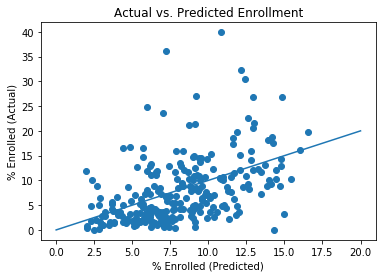

In [169]:
pred = result.predict(X)
plt.scatter(pred*100, data289_tmp.intl_pct)
plt.title('Actual vs. Predicted Enrollment')
plt.xlabel('% Enrolled (Predicted)')
plt.ylabel('% Enrolled (Actual)')
plt.plot([0,20],[0,20])

In [170]:
#MAE
np.mean(np.abs(pred*100 -data289_tmp.intl_pct))

4.20477760418198

# linear regression with logit transformation

(array([ 2.,  0.,  1.,  5., 13., 42., 69., 82., 39.,  9.]),
 array([-8.08517876, -7.31763883, -6.5500989 , -5.78255897, -5.01501903,
        -4.2474791 , -3.47993917, -2.71239924, -1.94485931, -1.17731938,
        -0.40977944]),
 <a list of 10 Patch objects>)

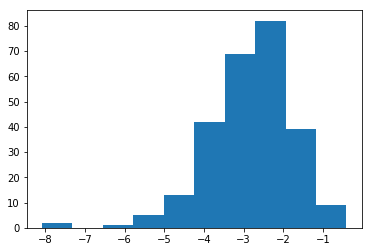

In [103]:
# get logit
logit = np.log(data289_tmp.intl_pct/(100-data289_tmp.intl_pct))
plt.hist(logit)

In [158]:
from sklearn.linear_model import LinearRegression
features_std = ['GRNRALT_rate_std','TUITION2_std','diverse_ind_std','avg_award_std','pct_awarded_std']
transformed_linear = LinearRegression()
result2 = transformed_linear.fit(X = data289_tmp[features_std],
                                y = logit)
result2.score(X = data289_tmp[features_std],
                                y = logit)
y_pred = result2.predict(X = data289_tmp[features_std])

Text(0, 0.5, '% Enrolled (Actual)')

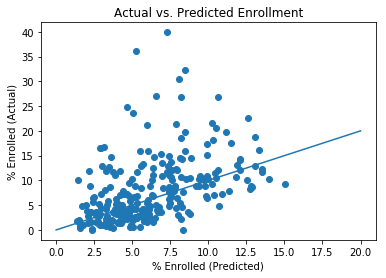

In [165]:
y_pred_orig = np.exp(y_pred)/(1+np.exp(y_pred))
plt.scatter(y_pred_orig*100, data289_tmp.intl_pct)
plt.plot([0,20],[0,20])
plt.title('Actual vs. Predicted Enrollment')
plt.xlabel('% Enrolled (Predicted)')
plt.ylabel('% Enrolled (Actual)')

In [156]:
result2.coef_
#result2.intercept_

array([0.23827549, 0.07992684, 0.01661433, 0.26475842, 0.24911236])

In [160]:
import statsmodels.api as sm
features_std = ['GRNRALT_rate_std','TUITION2_std','diverse_ind_std','avg_award_std','pct_awarded_std']
X = sm.add_constant(data289_tmp[features_std], prepend=False)
transformed_linear = sm.OLS(logit, X)
result2 = transformed_linear.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:               intl_pct   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     17.89
Date:                Thu, 03 Oct 2019   Prob (F-statistic):           3.28e-15
Time:                        00:06:16   Log-Likelihood:                -350.53
No. Observations:                 262   AIC:                             713.1
Df Residuals:                     256   BIC:                             734.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
GRNRALT_rate_std     0.2648      0.063  

C:\Users\Ning\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0.5, 1.0, 'Transferred Linear Regression coefficients')

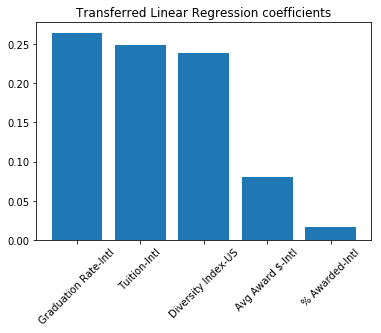

In [161]:
feature_names = ['Graduation Rate-Intl','Tuition-Intl','Diversity Index-US','Avg Award $-Intl', '% Awarded-Intl']
plt.bar(x = range(len(result2.params[:-1])), height = result2.params[:-1])
plt.xticks(range(len(result2.params[:-1])), feature_names, rotation = 45)
plt.title('Transferred Linear Regression coefficients')

In [166]:
#MAE
np.mean(np.abs(y_pred_orig*100 -data289_tmp.intl_pct))

3.874749150592693

# Calculate Reduction in MSE by feature importance

In [ ]:
# for now, just do the mean absolute error


In [ ]:
important_features = ['GRNRALT_rate_std','TUITION2_std','diverse_ind_std','avg_award_std','pct_awarded_std']